# Install Libraries

In [ ]:
!pip install ta
!pip install vnstock
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import ta
import itertools
from vnstock import Vnstock
from concurrent.futures import ProcessPoolExecutor

from math import floor
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from tqdm.auto import tqdm  # For progress tracking

# Data Collection

In [ ]:
def load_data(symbol, start_date='2020-01-01', end_date='2025-01-01'):
    """
    Load and preprocess symbol from vnstock.

    Parameters:
    - symbol (str): Ticker symbol ('VN30F1M' for futures).
    - start_date (str): Start date for data retrieval (format: 'YYYY-MM-DD').
    - end_date (str): End date for data retrieval (format: 'YYYY-MM-DD').

    Returns:
    - data (pd.DataFrame): data with OHLC columns.
    """
    # Initialize vnstock client
    stock = Vnstock().stock(symbol=symbol, source='TCBS')

    # Fetch historical OHLC data
    try:
        data = stock.quote.history(start=start_date, end=end_date)
    except Exception as e:
        raise ValueError(f"Failed to fetch data for {symbol}: {str(e)}")

    return data

In [ ]:
data_load = load_data('VN30F1M')

2025-04-22 16:57:18 - vnstock.common.data.data_explorer - INFO - Không phải là mã chứng khoán, thông tin công ty và tài chính không khả dụng.
INFO:vnstock.common.data.data_explorer:Không phải là mã chứng khoán, thông tin công ty và tài chính không khả dụng.
2025-04-22 16:57:19 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.
INFO:vnstock.common.data.data_explorer:TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.


# Data Processing

In [ ]:
def process_split_data(data: pd.DataFrame, split_date='2024-01-01'):
    """
    Process and split data for backtesting.

    Parameters:
    - data (pd.DataFrame): Raw data with OHLC columns.
    - split_date (str): Date to split in-sample and out-of-sample data (format: 'YYYY-MM-DD').

    Returns:
    - tuple: (in_sample_df, out_sample_df)
        - in_sample_df (pd.DataFrame): Preprocessed in-sample data with OHLC columns.
        - out_sample_df (pd.DataFrame): Preprocessed out-of-sample data with OHLC columns.
    """
    # Standardize column names (capitalize first letter)
    data = data.rename(columns=lambda x: x.capitalize())

    # Convert 'Time' column to datetime and set as index
    data['Time'] = pd.to_datetime(data['Time'])
    data = data.sort_values('Time').set_index('Time')

    # Remove duplicates and handle missing values
    data = data.drop_duplicates()
    data = data.dropna(subset=['Open', 'High', 'Low', 'Close'])

    # Split into in-sample and out-of-sample
    split_timestamp = pd.Timestamp(split_date)
    in_sample = data[data.index < split_timestamp]
    out_sample = data[data.index >= split_timestamp]

    # Ensure required columns are present
    required_columns = ['Open', 'High', 'Low', 'Close']
    for df in [in_sample, out_sample]:
        if not all(col in df.columns for col in required_columns):
            raise ValueError(f"Missing required columns in data: {required_columns}")

    return in_sample, out_sample

In [ ]:
in_sample_VN30F1M, out_sample_VN30F1M = process_split_data(data_load)

In [ ]:
in_sample_VN30F1M.to_csv('in_sample_VN30F1M.csv')
out_sample_VN30F1M.to_csv('out_sample_VN30F1M.csv')

# Load Data

In [60]:
in_sample_VN30F1M = pd.read_csv('in_sample_VN30F1M.csv', index_col=0, parse_dates=True)
out_sample_VN30F1M = pd.read_csv('out_sample_VN30F1M.csv', index_col=0, parse_dates=True)

In [61]:
in_sample_VN30F1M.head()

,Open,High,Low,Close,Volume
Time,,,,,
2020-01-06,877.5,883.5,871.6,872.0,83770
2020-01-07,873.9,877.8,871.6,875.0,83997
2020-01-08,868.0,871.0,863.4,863.7,90489
2020-01-09,869.1,876.2,868.7,874.8,75461
2020-01-10,876.1,884.4,875.4,878.7,82465


# Data Visualization

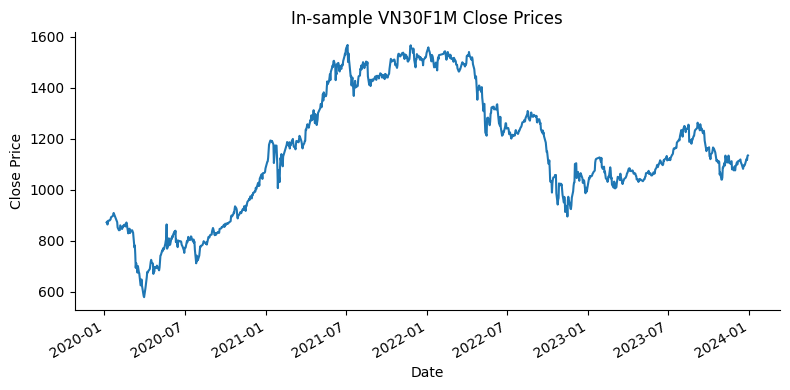

In [ ]:
in_sample_VN30F1M['Close'].plot(kind='line', figsize=(8, 4))
plt.title('In-sample VN30F1M Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig('in_sample_original.png', format='png', dpi=300)
plt.show()

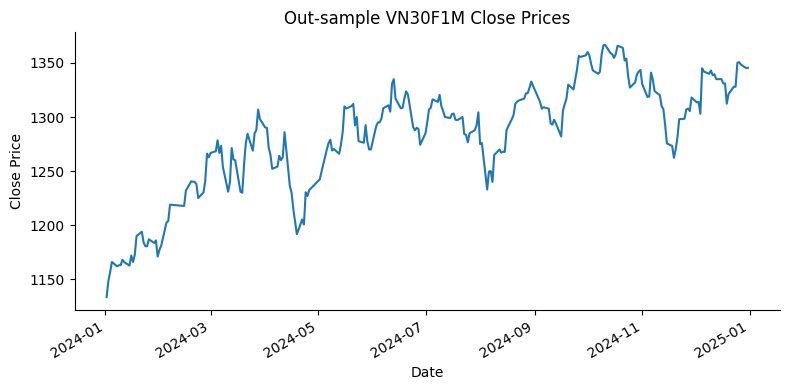

In [ ]:
out_sample_VN30F1M['Close'].plot(kind='line', figsize=(8, 4))
plt.title('Out-sample VN30F1M Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig('out_sample_original.png', format='png', dpi=300)
plt.show()

# Config

In [ ]:
ASSET_VALUE = 2 * (10 ** 8)
TAX = 0.47
MARGIN_RATIO = 0.175
ACCOUNT_RATIO = 0.8
MULTIPLIER = 10 ** 5

# Implementation

In [62]:
def algo(
    data: pd.DataFrame,
    momentum_fast_ema: int,
    momentum_slow_ema: int,
    momentum_signal_ema: int,
    momentum_rsi_window: int,
    momentum_rsi_threshold: int,
    momentum_atr_window: int,
    momentum_atr_multiplier: float,
    reversion_fast_ema: int,
    reversion_slow_ema: int,
    reversion_signal_ema: int,
    reversion_rsi_window: int,
    reversion_atr_window: int,
    reversion_atr_multiplier: float
) -> pd.DataFrame:
    """
    Executes a hybrid trading strategy that allocates capital between Momentum and
    Mean Reversion approaches, using MACD, RSI, and ATR-based conditions for
    position management.

    The algorithm processes historical OHLC data and simulates trading by:
    - Opening and closing positions based on technical indicators.
    - Splitting capital evenly between Momentum and Reversion strategies.
    - Tracking asset value over time, including both cash and unrealized P&L.

    Parameters:
        data (pd.DataFrame): Input dataframe with columns: ['Open', 'High', 'Low', 'Close'].
        momentum_fast_ema (int): Fast EMA period for Momentum MACD calculation.
        momentum_slow_ema (int): Slow EMA period for Momentum MACD calculation.
        momentum_signal_ema (int): Signal line EMA period for Momentum MACD.
        momentum_rsi_window (int): Window length for Momentum RSI.
        momentum_rsi_threshold (int): Threshold for overbought/oversold RSI levels in Momentum strategy.
        momentum_atr_window (int): ATR window size for Momentum stop-loss/take-profit.
        momentum_atr_multiplier (float): Multiplier for ATR-based exit levels in Momentum strategy.
        reversion_fast_ema (int): Fast EMA period for Reversion MACD calculation.
        reversion_slow_ema (int): Slow EMA period for Reversion MACD calculation.
        reversion_signal_ema (int): Signal line EMA period for Reversion MACD.
        reversion_rsi_window (int): Window length for Reversion RSI.
        reversion_atr_window (int): ATR window size for Reversion stop-loss/take-profit.
        reversion_atr_multiplier (float): Multiplier for ATR-based exit levels in Reversion strategy.

    Returns:
        pd.DataFrame: DataFrame indexed by date with columns:
            - 'Asset': Total portfolio value (cash + unrealized P&L) at each timestep.
            - 'Return': Percentage return compared to the previous timestep.
    """
    data = data.copy()
    price_multiplier = MULTIPLIER * MARGIN_RATIO / ACCOUNT_RATIO

    cash = ASSET_VALUE
    holdings_momentum = []
    holdings_reversion = []
    trading_data = pd.DataFrame(index=data.index, columns=['Asset'])
    trading_data['Asset'] = cash
    trading_data['Asset'] = trading_data['Asset'].astype(float)

    # Calculate technical indicators for Momentum
    data['MACD_diff_mom'] = ta.trend.macd_diff(
        data['Close'], window_slow=momentum_slow_ema, window_fast=momentum_fast_ema, window_sign=momentum_signal_ema
    )
    data['RSI_mom'] = ta.momentum.rsi(data['Close'], window=momentum_rsi_window)
    data['ATR_mom'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window=momentum_atr_window)

    # Calculate technical indicators for Mean Reversion
    data['MACD_diff_rev'] = ta.trend.macd_diff(
        data['Close'], window_slow=reversion_slow_ema, window_fast=reversion_fast_ema, window_sign=reversion_signal_ema
    )
    data['RSI_rev'] = ta.momentum.rsi(data['Close'], window=reversion_rsi_window)
    data['ATR_rev'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window=reversion_atr_window)

    for i in range(1, len(data)):
        row = data.iloc[i]
        if (pd.isna(row['RSI_mom']) or pd.isna(row['MACD_diff_mom']) or pd.isna(row['ATR_mom']) or
            pd.isna(row['RSI_rev']) or pd.isna(row['MACD_diff_rev']) or pd.isna(row['ATR_rev'])
        ): continue
        date = data.index[i]
        cur_price = row['Close']

        # Exit Momentum Positions
        for position in holdings_momentum[:]:
            entry_date, pos_type, entry_price, quantity, stop_loss, take_profit = position
            if pos_type == 'LONG' and (
                cur_price >= take_profit or cur_price <= stop_loss or
                row['RSI_mom'] >= (100 - momentum_rsi_threshold) or row['MACD_diff_mom'] < 0
            ):
                cash += quantity * cur_price * price_multiplier - quantity * TAX * MULTIPLIER
                holdings_momentum.remove(position)
            elif pos_type == 'SHORT' and (
                cur_price <= take_profit or cur_price >= stop_loss or
                row['RSI_mom'] <= momentum_rsi_threshold or row['MACD_diff_mom'] > 0
            ):
                cash -= quantity * cur_price * price_multiplier + quantity * TAX * MULTIPLIER
                holdings_momentum.remove(position)

        # Exit Mean Reversion Positions
        for position in holdings_reversion[:]:
            entry_date, pos_type, entry_price, quantity, stop_loss, take_profit = position
            if pos_type == 'LONG' and (
                cur_price >= take_profit or cur_price <= stop_loss or row['RSI_rev'] >= 50 or row['MACD_diff_rev'] < 0
            ):
                cash += quantity * cur_price * price_multiplier - quantity * TAX * MULTIPLIER
                holdings_reversion.remove(position)
            elif pos_type == 'SHORT' and (
                cur_price <= take_profit or cur_price >= stop_loss or row['RSI_rev'] >= 50 or row['MACD_diff_rev'] > 0
            ):
                cash -= quantity * cur_price * price_multiplier + quantity * TAX * MULTIPLIER
                holdings_reversion.remove(position)

        total_unrealized = sum(
            cur_price * price_multiplier * pos[3] if pos[1] == 'LONG'
            else -cur_price * price_multiplier * pos[3] for pos in holdings_momentum + holdings_reversion
        )
        trading_data.loc[date, 'Asset'] = cash + total_unrealized

        available_cash = cash / 2
        # Momentum Entry Logic
        if not holdings_momentum:
            if row['MACD_diff_mom'] > 0 and 50 < row['RSI_mom'] < (100 - momentum_rsi_threshold):
                quantity = floor(available_cash / (cur_price * price_multiplier))
                if quantity > 0:
                    cash -= quantity * cur_price * price_multiplier
                    stop_loss = cur_price - row['ATR_mom'] * momentum_atr_multiplier
                    take_profit = cur_price + row['ATR_mom'] * momentum_atr_multiplier
                    holdings_momentum.append((date, 'LONG', cur_price, quantity, stop_loss, take_profit))
            elif row['MACD_diff_mom'] < 0 and momentum_rsi_threshold < row['RSI_mom'] < 50:
                quantity = floor(available_cash / (cur_price * price_multiplier))
                if quantity > 0:
                    cash += quantity * cur_price * price_multiplier
                    stop_loss = cur_price + row['ATR_mom'] * momentum_atr_multiplier
                    take_profit = cur_price - row['ATR_mom'] * momentum_atr_multiplier
                    holdings_momentum.append((date, 'SHORT', cur_price, quantity, stop_loss, take_profit))

        # Mean Reversion Entry Logic
        if not holdings_reversion:
            if row['MACD_diff_rev'] > 0 and row['RSI_rev'] < 30:
                quantity = floor(available_cash / (cur_price * price_multiplier))
                if quantity > 0:
                    cash -= quantity * cur_price * price_multiplier
                    stop_loss = cur_price - row['ATR_rev'] * reversion_atr_multiplier
                    take_profit = cur_price + row['ATR_rev'] * reversion_atr_multiplier
                    holdings_reversion.append((date, 'LONG', cur_price, quantity, stop_loss, take_profit))
            elif row['MACD_diff_rev'] < 0 and row['RSI_rev'] > 70:
                quantity = min(floor(available_cash / (cur_price * price_multiplier)), 3)
                if quantity > 0:
                    cash += quantity * cur_price * price_multiplier
                    stop_loss = cur_price + row['ATR_rev'] * reversion_atr_multiplier
                    take_profit = cur_price - row['ATR_rev'] * reversion_atr_multiplier
                    holdings_reversion.append((date, 'SHORT', cur_price, quantity, stop_loss, take_profit))

    trading_data['Return'] = trading_data['Asset'].pct_change()

    return trading_data


In [63]:
def dynamic_algo(
    data: pd.DataFrame,
    momentum_fast_ema: int,
    momentum_slow_ema: int,
    momentum_signal_ema: int,
    momentum_rsi_window: int,
    momentum_rsi_threshold: int,
    momentum_atr_window: int,
    reversion_fast_ema: int,
    reversion_slow_ema: int,
    reversion_signal_ema: int,
    reversion_rsi_window: int,
    reversion_atr_window: int
) -> pd.DataFrame:
    """
    Executes a dynamic hybrid trading strategy combining Momentum and Mean Reversion models,
    driven by MACD, RSI, and ATR indicators.

    This algorithm allocates capital evenly between two strategies: Momentum and Mean Reversion.

    A key feature of this strategy is its adaptive position sizing logic:
    ATR-based stop-loss and take-profit levels are dynamically adjusted at each time step
    depending on short-term vs long-term volatility (measured by short and long ATR windows).
    This allows the system to widen or tighten risk thresholds based on changing market conditions.

    Parameters:
        data (pd.DataFrame): Historical OHLCV data with at least 'High', 'Low', 'Close' columns.
        momentum_fast_ema (int): Fast EMA period for Momentum MACD.
        momentum_slow_ema (int): Slow EMA period for Momentum MACD.
        momentum_signal_ema (int): Signal line EMA period for Momentum MACD.
        momentum_rsi_window (int): RSI window for Momentum strategy.
        momentum_rsi_threshold (int): Threshold used to define RSI extreme zones.
        momentum_atr_window (int): ATR window for base Momentum volatility.
        reversion_fast_ema (int): Fast EMA period for Reversion MACD.
        reversion_slow_ema (int): Slow EMA period for Reversion MACD.
        reversion_signal_ema (int): Signal line EMA period for Reversion MACD.
        reversion_rsi_window (int): RSI window for Reversion strategy.
        reversion_atr_window (int): ATR window for base Reversion volatility.

    Returns:
        pd.DataFrame: Time series of the simulated portfolio, with:
            - 'Asset': Total asset value (cash + unrealized positions).
            - 'Return': Daily percentage change of the asset value.
    """
    data = data.copy()
    price_multiplier = MULTIPLIER * MARGIN_RATIO / ACCOUNT_RATIO

    cash = ASSET_VALUE
    holdings_momentum = []
    holdings_reversion = []
    trading_data = pd.DataFrame(index=data.index, columns=['Asset'])
    trading_data['Asset'] = cash
    trading_data['Asset'] = trading_data['Asset'].astype(float)

    # Calculate technical indicators for Momentum
    data['MACD_diff_mom'] = ta.trend.macd_diff(
        data['Close'], window_slow=momentum_slow_ema, window_fast=momentum_fast_ema, window_sign=momentum_signal_ema
    )
    data['RSI_mom'] = ta.momentum.rsi(data['Close'], window=momentum_rsi_window)
    data['ATR_mom'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window=momentum_atr_window)
    data['ATR_mom_short'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window = 10)
    data['ATR_mom_long'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window = 20)

    # Calculate technical indicators for Mean Reversion
    data['MACD_diff_rev'] = ta.trend.macd_diff(
        data['Close'], window_slow=reversion_slow_ema, window_fast=reversion_fast_ema, window_sign=reversion_signal_ema
    )
    data['RSI_rev'] = ta.momentum.rsi(data['Close'], window=reversion_rsi_window)
    data['ATR_rev'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window=reversion_atr_window)
    data['ATR_rev_short'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window = 7)
    data['ATR_rev_long'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window = 14)

    for i in range(1, len(data)):
        row = data.iloc[i]
        if (pd.isna(row['RSI_mom']) or pd.isna(row['MACD_diff_mom']) or pd.isna(row['ATR_mom']) or
            pd.isna(row['RSI_rev']) or pd.isna(row['MACD_diff_rev']) or pd.isna(row['ATR_rev'])
        ): continue
        date = data.index[i]
        cur_price = row['Close']

        # Determine ATR multiplier based on volatility trend
        if row['ATR_mom_short'] > row['ATR_mom_long']:
            momentum_atr_multiplier = 3.0  # Higher volatility → wider SL/TP
        else:
            momentum_atr_multiplier = 2.0  # Lower volatility → tighter SL/TP
        if row['ATR_rev_short'] > row['ATR_rev_long']:
            reversion_atr_multiplier = 2.0  # Higher volatility → wider SL/TP
        else:
            reversion_atr_multiplier = 1.5  # Lower volatility → tighter SL/TP

        # Exit Momentum Positions
        for position in holdings_momentum[:]:
            entry_date, pos_type, entry_price, quantity, stop_loss, take_profit = position
            if pos_type == 'LONG' and (
                cur_price >= take_profit or cur_price <= stop_loss or
                row['RSI_mom'] >= (100 - momentum_rsi_threshold) or row['MACD_diff_mom'] < 0
            ):
                cash += quantity * cur_price * price_multiplier - quantity * TAX * MULTIPLIER
                holdings_momentum.remove(position)
            elif pos_type == 'SHORT' and (
                cur_price <= take_profit or cur_price >= stop_loss or
                row['RSI_mom'] <= momentum_rsi_threshold or row['MACD_diff_mom'] > 0
            ):
                cash -= quantity * cur_price * price_multiplier + quantity * TAX * MULTIPLIER
                holdings_momentum.remove(position)

        # Exit Mean Reversion Positions
        for position in holdings_reversion[:]:
            entry_date, pos_type, entry_price, quantity, stop_loss, take_profit = position
            if pos_type == 'LONG' and (
                cur_price >= take_profit or cur_price <= stop_loss or row['RSI_rev'] >= 50 or row['MACD_diff_rev'] < 0
            ):
                cash += quantity * cur_price * price_multiplier - quantity * TAX * MULTIPLIER
                holdings_reversion.remove(position)
            elif pos_type == 'SHORT' and (
                cur_price <= take_profit or cur_price >= stop_loss or row['RSI_rev'] >= 50 or row['MACD_diff_rev'] > 0
            ):
                cash -= quantity * cur_price * price_multiplier + quantity * TAX * MULTIPLIER
                holdings_reversion.remove(position)

        total_unrealized = sum(
            cur_price * price_multiplier * pos[3] if pos[1] == 'LONG'
            else -cur_price * price_multiplier * pos[3] for pos in holdings_momentum + holdings_reversion
        )
        trading_data.loc[date, 'Asset'] = cash + total_unrealized

        available_cash = cash / 2
        # Momentum Entry Logic
        if not holdings_momentum:
            if row['MACD_diff_mom'] > 0 and 50 < row['RSI_mom'] < (100 - momentum_rsi_threshold):
                quantity = floor(available_cash / (cur_price * price_multiplier))
                if quantity > 0:
                    cash -= quantity * cur_price * price_multiplier
                    stop_loss = cur_price - row['ATR_mom'] * momentum_atr_multiplier
                    take_profit = cur_price + row['ATR_mom'] * momentum_atr_multiplier
                    holdings_momentum.append((date, 'LONG', cur_price, quantity, stop_loss, take_profit))
            elif row['MACD_diff_mom'] < 0 and momentum_rsi_threshold < row['RSI_mom'] < 50:
                quantity = floor(available_cash / (cur_price * price_multiplier))
                if quantity > 0:
                    cash += quantity * cur_price * price_multiplier
                    stop_loss = cur_price + row['ATR_mom'] * momentum_atr_multiplier
                    take_profit = cur_price - row['ATR_mom'] * momentum_atr_multiplier
                    holdings_momentum.append((date, 'SHORT', cur_price, quantity, stop_loss, take_profit))

        # Mean Reversion Entry Logic
        if not holdings_reversion:
            if row['MACD_diff_rev'] > 0 and row['RSI_rev'] < 30:
                quantity = floor(available_cash / (cur_price * price_multiplier))
                if quantity > 0:
                    cash -= quantity * cur_price * price_multiplier
                    stop_loss = cur_price - row['ATR_rev'] * reversion_atr_multiplier
                    take_profit = cur_price + row['ATR_rev'] * reversion_atr_multiplier
                    holdings_reversion.append((date, 'LONG', cur_price, quantity, stop_loss, take_profit))
            elif row['MACD_diff_rev'] < 0 and row['RSI_rev'] > 70:
                quantity = min(floor(available_cash / (cur_price * price_multiplier)), 3)
                if quantity > 0:
                    cash += quantity * cur_price * price_multiplier
                    stop_loss = cur_price + row['ATR_rev'] * reversion_atr_multiplier
                    take_profit = cur_price - row['ATR_rev'] * reversion_atr_multiplier
                    holdings_reversion.append((date, 'SHORT', cur_price, quantity, stop_loss, take_profit))

    trading_data['Return'] = trading_data['Asset'].pct_change()

    return trading_data



# Utils

In [ ]:
def maximum_drawdown(data: pd.DataFrame) -> float:
    data['peak'] = data['Asset'].cummax()
    data['drawdown'] = data['Asset'] / data['peak'] - 1
    return data['drawdown'].min() * 100

def sharpe_ratio(data: pd.DataFrame) -> float:
    daily_return = data['Asset'][1:].to_numpy() / data['Asset'][:-1].to_numpy() - 1
    trading_days_per_year = 252
    risk_free_rate = 0.03093 # e.g. government bonds interest is 3% per year

    annual_std = np.sqrt(252) * np.std(daily_return, ddof=1)
    annual_return = 252 * np.mean(daily_return) - risk_free_rate

    return annual_return / annual_std if annual_std != 0 else 0

def longest_drawdown(data: pd.DataFrame) -> int:
    # Initial and peak asset
    cur_asset = 1
    peak = 1

    period_returns = data['Return'].dropna()

    if period_returns.empty:
        raise ValueError("Period returns is empty")
    if period_returns.isin([-1]).any():
        raise ValueError("All capital of the portfolio is lost")

    count = 0
    ldd = 0
    for val in period_returns:
        cur_asset *= (1 + val)
        if cur_asset >= peak:
            peak = cur_asset
            ldd = max(ldd, count)
            count = 0
        else:
            count += 1
    ldd = max(ldd, count)
    return ldd

def sortino_ratio(data: pd.DataFrame, risk_free_return: float = 0.03093) -> float:
    period_returns = data['Return'].dropna()
    if period_returns.empty:
        raise ValueError("Period returns is empty")

    downside_risk = np.sqrt(np.mean([0 if val > risk_free_return else (val - risk_free_return) ** 2 for val in period_returns]))
    if downside_risk == 0:
        return 0

    return round((np.sqrt(252) * np.mean(period_returns) - risk_free_return) / downside_risk, 6)

def holding_period_returns(data: pd.DataFrame) -> float:
    cur_asset_value = data['Asset'].iloc[-1]
    init_asset_value = data['Asset'].iloc[0]
    return round((cur_asset_value / init_asset_value - 1) * 100, 6)

# In-sample Back-Testing

## Non Dynamic

In [64]:
# Non-dynamic Parameters
MOMENTUM_FAST_EMA = 10
MOMENTUM_SLOW_EMA = 15
MOMENTUM_SIGNAL_EMA = 5
MOMENTUM_RSI_WINDOW = 10
MOMENTUM_RSI_THRESHOLD = 30
MOMENTUM_ATR_WINDOW = 7
MOMENTUM_ATR_MULTIPLIER = 2.0

REVERSION_FAST_EMA = 20
REVERSION_SLOW_EMA = 20
REVERSION_SIGNAL_EMA = 5
REVERSION_RSI_WINDOW = 10
REVERSION_ATR_WINDOW = 7
REVERSION_ATR_MULTIPLIER = 1.5

data = in_sample_VN30F1M.copy()

In [65]:
result = algo(
    data,
    MOMENTUM_FAST_EMA, MOMENTUM_SLOW_EMA, MOMENTUM_SIGNAL_EMA,
    MOMENTUM_RSI_WINDOW, MOMENTUM_RSI_THRESHOLD, MOMENTUM_ATR_WINDOW, MOMENTUM_ATR_MULTIPLIER,
    REVERSION_FAST_EMA, REVERSION_SLOW_EMA, REVERSION_SIGNAL_EMA,
    REVERSION_RSI_WINDOW, REVERSION_ATR_WINDOW, REVERSION_ATR_MULTIPLIER
)

Holding Period Return: 28.74%
Holding Period: từ 2020-01-06 00:00:00 đến 2023-12-29 00:00:00


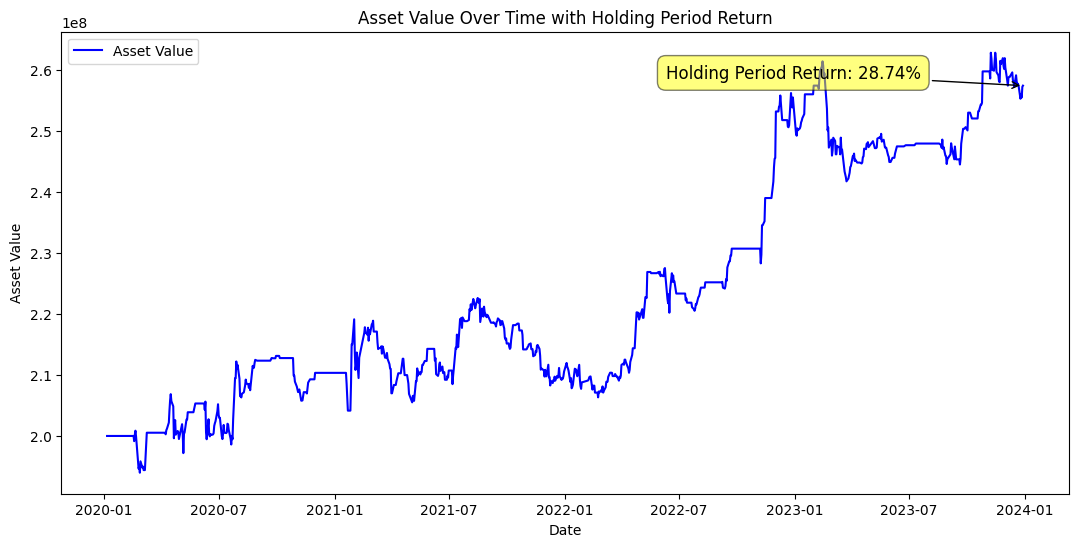

-7.531484869621585
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Peak date: 2023-02-14 00:00:00
Trough date: 2023-03-24 00:00:00
MDD: -7.531484869621585 %


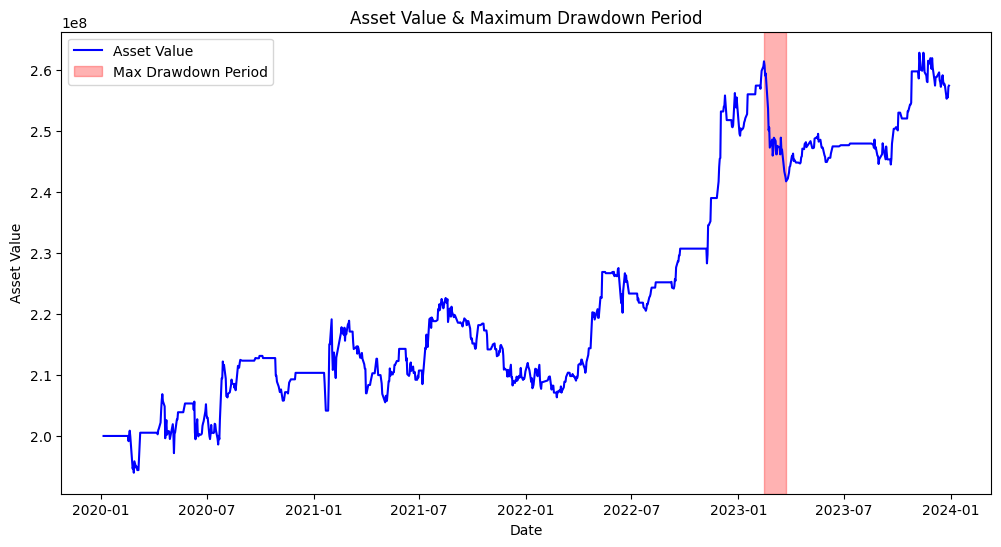

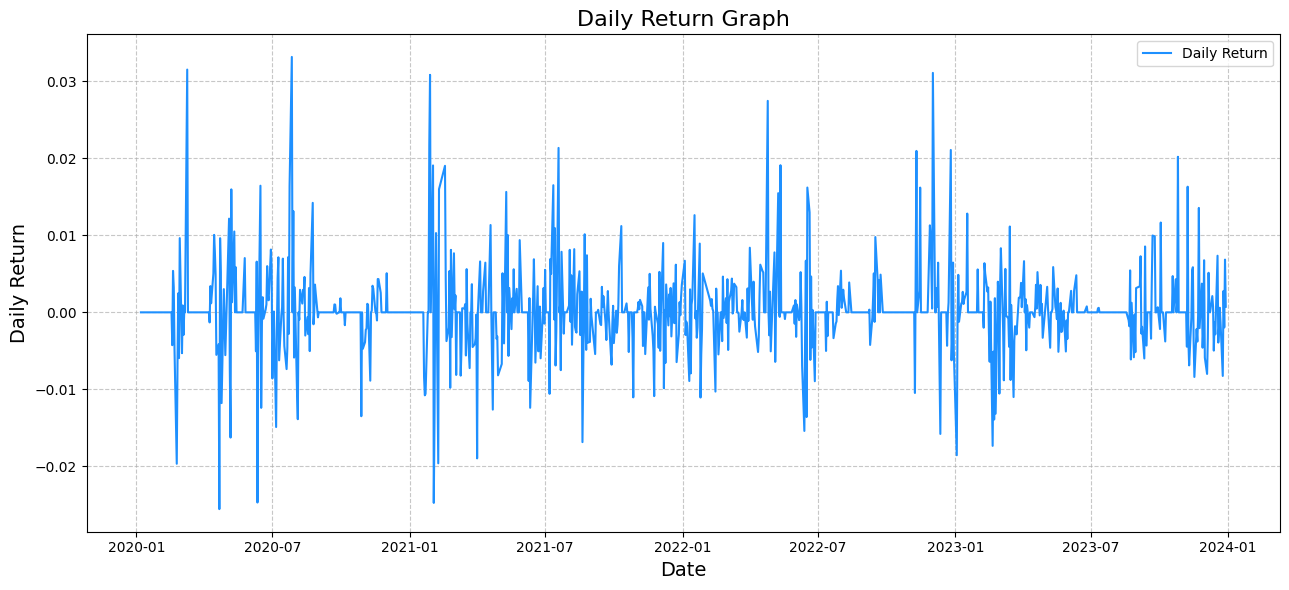

Sharpe Ratio:  0.4211341891273424


In [66]:
init_date = result.index[0]
cur_date = result.index[-1]
cur_asset_value = result['Asset'].iloc[-1]
init_asset_value = result['Asset'].iloc[0]
accum_return_rate = (cur_asset_value / init_asset_value - 1) * 100
print(f"Holding Period Return: {accum_return_rate:.2f}%")
print(f"Holding Period: từ {init_date} đến {cur_date}")


plt.figure(figsize=(13, 6))
plt.plot(result.index, result['Asset'], label='Asset Value', color='blue')
plt.xlabel('Date')
plt.ylabel('Asset Value')
plt.title('Asset Value Over Time with Holding Period Return')
plt.annotate(
    f"Holding Period Return: {accum_return_rate:.2f}%", xy = (data.index[-1], cur_asset_value),
    xytext = (0.6, 0.9), textcoords = 'axes fraction', arrowprops = dict(facecolor = 'black', arrowstyle = '->'),
    bbox = dict(boxstyle = 'round, pad = 0.5', fc = 'yellow', alpha = 0.5), fontsize = 12
)
plt.legend()
plt.show()

mdd_value = maximum_drawdown(result)
print(mdd_value)
trough_date = result['drawdown'].idxmin()
print(type(trough_date))

# ----------------------------
peak_date = result.loc[:trough_date, 'Asset'].idxmax()
print("Peak date:", peak_date)
print("Trough date:", trough_date)
print("MDD:", result['drawdown'].min() * 100, "%")
plt.figure(figsize=(12, 6))
plt.plot(data.index, result['Asset'], label='Asset Value', color='blue')
plt.axvspan(float(mdates.date2num(trough_date)), float(mdates.date2num(peak_date)), color = 'red', alpha = 0.3, label = 'Max Drawdown Period')
plt.xlabel('Date')
plt.ylabel('Asset Value')
plt.title('Asset Value & Maximum Drawdown Period')
plt.legend()
plt.show()


# ------------------------------

daily_return = result['Asset'].pct_change().dropna()
plt.figure(figsize = (13, 6))
plt.plot(result.index[1:], daily_return, linestyle = '-', color = 'dodgerblue', label = 'Daily Return')
plt.title("Daily Return Graph", fontsize = 16)
plt.xlabel("Date", fontsize = 14)
plt.ylabel("Daily Return", fontsize = 14)
plt.legend()
plt.grid(True, linestyle='--', alpha = 0.7)
plt.tight_layout()
plt.show()
sharpe = sharpe_ratio(result)
print("Sharpe Ratio: ", sharpe)

## Dynamic

In [67]:
# Dynamic Parameters
MOMENTUM_FAST_EMA = 10
MOMENTUM_SLOW_EMA = 15
MOMENTUM_SIGNAL_EMA = 5
MOMENTUM_RSI_WINDOW = 10
MOMENTUM_RSI_THRESHOLD = 30
MOMENTUM_ATR_WINDOW = 7

REVERSION_FAST_EMA = 20
REVERSION_SLOW_EMA = 20
REVERSION_SIGNAL_EMA = 5
REVERSION_RSI_WINDOW = 10
REVERSION_ATR_WINDOW = 7
data = in_sample_VN30F1M.copy()

In [68]:
result = dynamic_algo(
    data,
    MOMENTUM_FAST_EMA, MOMENTUM_SLOW_EMA, MOMENTUM_SIGNAL_EMA,MOMENTUM_RSI_WINDOW, MOMENTUM_RSI_THRESHOLD, MOMENTUM_ATR_WINDOW,
    REVERSION_FAST_EMA, REVERSION_SLOW_EMA, REVERSION_SIGNAL_EMA, REVERSION_RSI_WINDOW, REVERSION_ATR_WINDOW
)

Holding Period Return: 30.13%
Holding Period: từ 2020-01-06 00:00:00 đến 2023-12-29 00:00:00


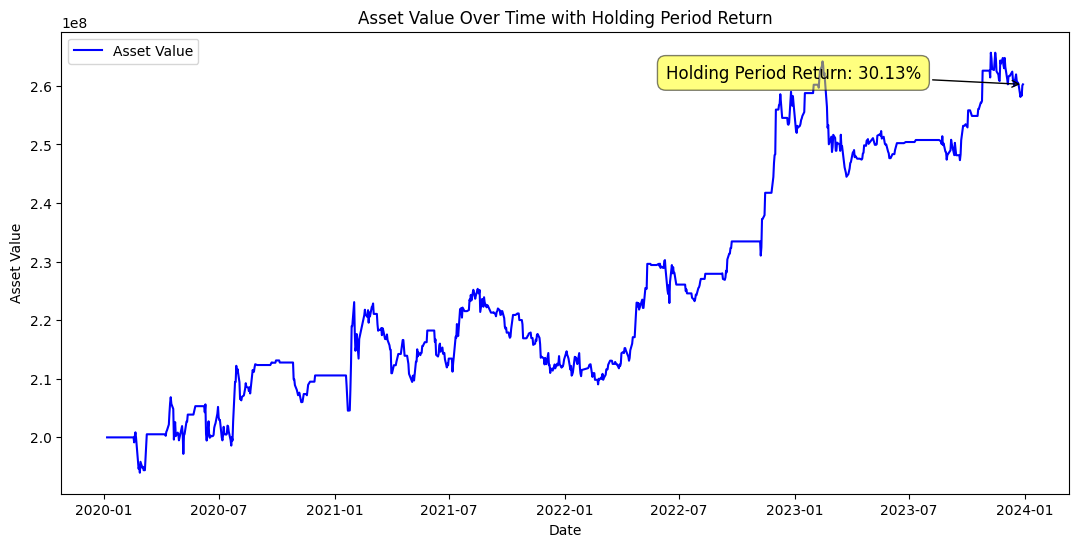

-7.454033754240097
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Peak date: 2023-02-14 00:00:00
Trough date: 2023-03-24 00:00:00
MDD: -7.454033754240097 %


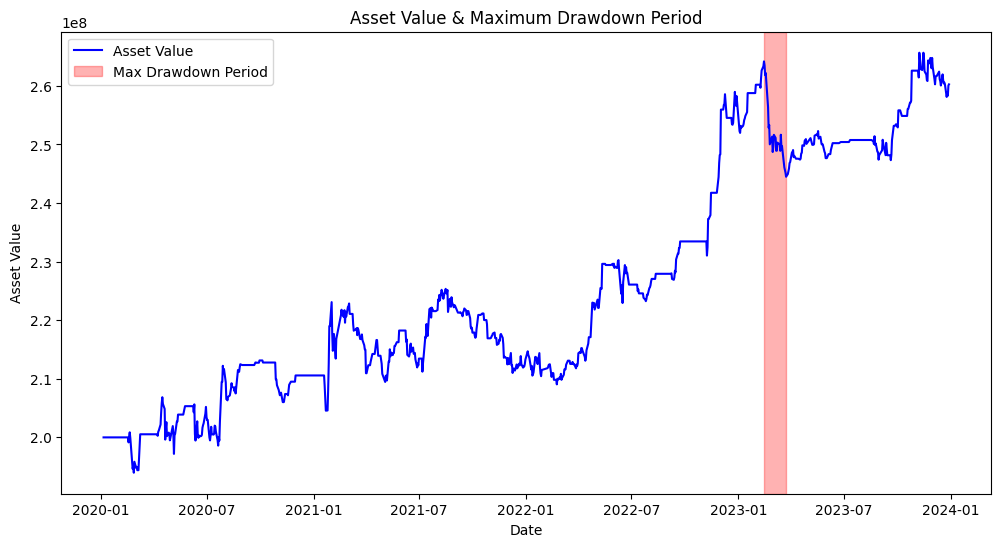

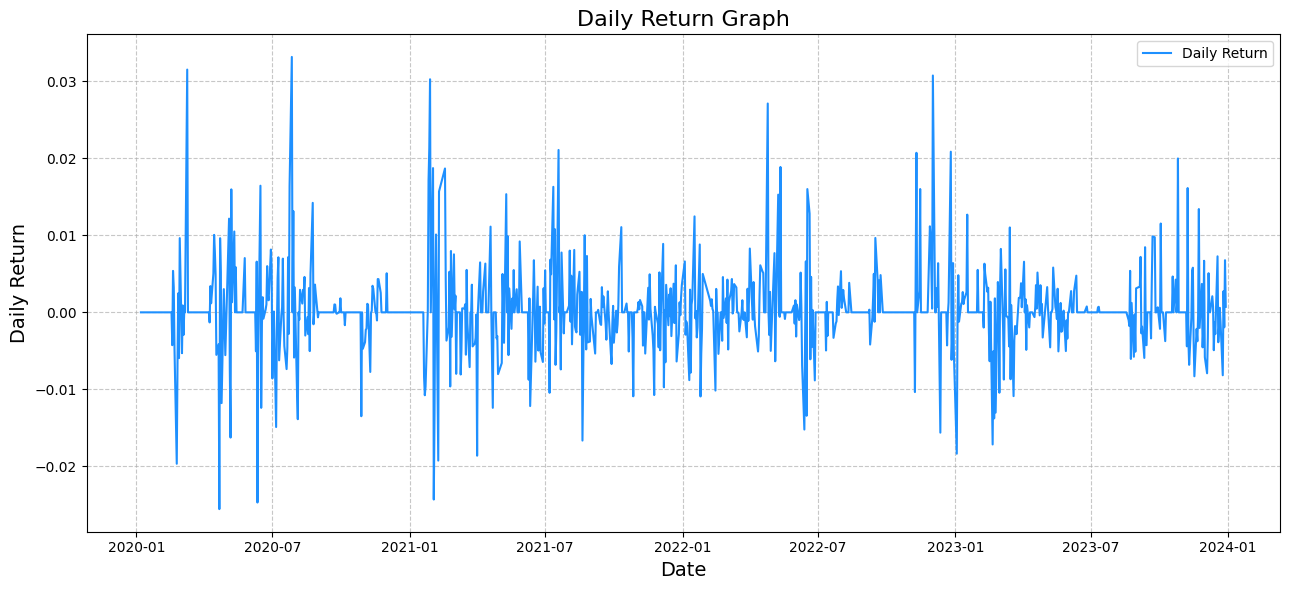

Sharpe Ratio:  0.4541313620339743


In [69]:
init_date = result.index[0]
cur_date = result.index[-1]
cur_asset_value = result['Asset'].iloc[-1]
init_asset_value = result['Asset'].iloc[0]
accum_return_rate = (cur_asset_value / init_asset_value - 1) * 100
print(f"Holding Period Return: {accum_return_rate:.2f}%")
print(f"Holding Period: từ {init_date} đến {cur_date}")


plt.figure(figsize=(13, 6))
plt.plot(result.index, result['Asset'], label='Asset Value', color='blue')
plt.xlabel('Date')
plt.ylabel('Asset Value')
plt.title('Asset Value Over Time with Holding Period Return')
plt.annotate(
    f"Holding Period Return: {accum_return_rate:.2f}%", xy = (data.index[-1], cur_asset_value),
    xytext = (0.6, 0.9), textcoords = 'axes fraction', arrowprops = dict(facecolor = 'black', arrowstyle = '->'),
    bbox = dict(boxstyle = 'round, pad = 0.5', fc = 'yellow', alpha = 0.5), fontsize = 12
)
plt.legend()
plt.show()

mdd_value = maximum_drawdown(result)
print(mdd_value)
trough_date = result['drawdown'].idxmin()
print(type(trough_date))

# ----------------------------
peak_date = result.loc[:trough_date, 'Asset'].idxmax()
print("Peak date:", peak_date)
print("Trough date:", trough_date)
print("MDD:", result['drawdown'].min() * 100, "%")
plt.figure(figsize=(12, 6))
plt.plot(data.index, result['Asset'], label='Asset Value', color='blue')
plt.axvspan(float(mdates.date2num(trough_date)), float(mdates.date2num(peak_date)), color = 'red', alpha = 0.3, label = 'Max Drawdown Period')
plt.xlabel('Date')
plt.ylabel('Asset Value')
plt.title('Asset Value & Maximum Drawdown Period')
plt.legend()
plt.show()


# ------------------------------

daily_return = result['Asset'].pct_change().dropna()
plt.figure(figsize = (13, 6))
plt.plot(result.index[1:], daily_return, linestyle = '-', color = 'dodgerblue', label = 'Daily Return')
plt.title("Daily Return Graph", fontsize = 16)
plt.xlabel("Date", fontsize = 14)
plt.ylabel("Daily Return", fontsize = 14)
plt.legend()
plt.grid(True, linestyle='--', alpha = 0.7)
plt.tight_layout()
plt.show()
sharpe = sharpe_ratio(result)
print("Sharpe Ratio: ", sharpe)

# Optimization

## Loss score

In [ ]:
def loss_score(hpr: float, mdd: float, ldd: int, sharpe: float, sortino: float) -> float:
    return round(hpr + mdd / 10 - ldd / 100 + ((sharpe + sortino) / 2) ** 3, 6)

## Momentum

In [ ]:
def momentum_algo(
    data: pd.DataFrame,
    fast_ema_window: int,
    slow_ema_window: int,
    ema_signal_window: int,
    rsi_window: int,
    rsi_threshold: int,
    atr_window: int,
    atr_multiplier: float
    ) -> pd.DataFrame:
    """
    Executes a momentum-based trading strategy using MACD, RSI, and ATR indicators.

    This algorithm seeks to identify and exploit price trends (momentum) by:
    - Opening positions when MACD and RSI jointly signal trend confirmation.
    - Closing positions on reaching take-profit or stop-loss thresholds,
      or when technical indicators suggest weakening momentum.

    Stop-loss and take-profit levels are automatically determined at the time of entry,
    based on the Average True Range (ATR) and a configurable multiplier,
    allowing the system to adapt to market volatility.

    Parameters:
        data (pd.DataFrame): Historical OHLC data with at least the following columns: ['High', 'Low', 'Close'].
        fast_ema_window (int): EMA window size for the fast component of the MACD.
        slow_ema_window (int): EMA window size for the slow component of the MACD.
        ema_signal_window (int): EMA window for the MACD signal line.
        rsi_window (int): Window size for the RSI indicator.
        rsi_threshold (int): RSI threshold to define overbought/oversold conditions.
        atr_window (int): Window size for the Average True Range (ATR) calculation.
        atr_multiplier (float): Multiplier for ATR to compute stop-loss and take-profit levels.

    Returns:
        pd.DataFrame: A DataFrame indexed by date containing:
            - 'Asset': Simulated portfolio value (cash + unrealized positions) over time.
            - 'Return': Daily percentage change in portfolio value.

    Notes:
        - Position sizing is based on using 50% of available cash at the time of entry.
        - Positions are only opened if no other positions are active.
        - The strategy supports both long and short positions.
    """
    data = data.copy()
    price_multiplier = MULTIPLIER * MARGIN_RATIO / ACCOUNT_RATIO

    # Initialize trading variables
    cash = ASSET_VALUE
    holdings = []  # List of (entry_date, pos_type, entry_price, quantity, stop_loss_price, take_profit_price)
    trading_data = pd.DataFrame(index = data.index, columns = ['Asset'])
    trading_data['Asset'] = cash
    trading_data['Asset'] = trading_data['Asset'].astype(float)

    # Calculate technical indicators
    data['MACD_diff'] = ta.trend.macd_diff(
        data['Close'], window_slow=fast_ema_window, window_fast=slow_ema_window, window_sign=ema_signal_window
    )
    data['RSI'] = ta.momentum.rsi(data['Close'], window = rsi_window)
    data['ATR'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window = atr_window)

    # Trading loop starting from the second day
    for i in range(1, len(data)):
        row = data.iloc[i]
        if pd.isna(row['RSI']) or pd.isna(row['MACD_diff']) or pd.isna(row['ATR']):
            continue
        date = data.index[i]
        cur_price = row['Close']

        # Check for positions to close
        for position in holdings[:]:
            entry_date, pos_type, entry_price, quantity, stop_loss_price, take_profit_price = position

            if pos_type == 'LONG':
                if (cur_price >= take_profit_price or cur_price <= stop_loss_price or
                    row['RSI'] >= (100 - rsi_threshold) or row['MACD_diff'] < 0):
                    # Closing a LONG position (selling)
                    cash += quantity * cur_price * price_multiplier - quantity * TAX * MULTIPLIER
                    holdings.remove(position)
            else:  # SHORT
                if (cur_price <= take_profit_price or cur_price >= stop_loss_price or
                    row['RSI'] <= rsi_threshold or row['MACD_diff'] > 0):
                    # Closing a SHORT position (buying back)
                    cash -= quantity * cur_price * price_multiplier + quantity * TAX * MULTIPLIER
                    holdings.remove(position)

        # Calculate unrealized P&L and update asset value
        total_unrealized_pnf = sum(
            cur_price * price_multiplier * pos[3] if pos[1] == 'LONG'
            else -cur_price * price_multiplier * pos[3] for pos in holdings
        )
        asset_value = cash + total_unrealized_pnf
        trading_data.loc[date, 'Asset'] = asset_value

        # Open new position if no holdings
        if not holdings:

            # LONG position entry conditions
            if row['MACD_diff'] > 0 and 50 < row['RSI'] < (100 - rsi_threshold):
                # Use half of cash, accounting for TAX
                quantity = floor((cash / 2) / (cur_price * price_multiplier))
                if quantity > 0:
                    cash -= quantity * cur_price * price_multiplier
                    stop_loss_price = cur_price - row['ATR'] * atr_multiplier
                    take_profit_price = cur_price + row['ATR'] * atr_multiplier
                    holdings.append((date, 'LONG', cur_price, quantity, stop_loss_price, take_profit_price))

            # SHORT position entry conditions
            elif row['MACD_diff'] < 0 and rsi_threshold < row['RSI'] < 50:
                # Use half of cash to determine quantity
                quantity = min(floor((cash / 2) / (cur_price * price_multiplier)), 3)
                if quantity > 0:
                    cash += quantity * cur_price * price_multiplier
                    stop_loss_price = cur_price + row['ATR'] * atr_multiplier
                    take_profit_price = cur_price - row['ATR'] * atr_multiplier
                    holdings.append((date, 'SHORT', cur_price, quantity, stop_loss_price, take_profit_price))

    trading_data['Return'] = trading_data['Asset'].pct_change()

    return trading_data

In [ ]:
def momentum_optimize(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()

    fast_ema_range = range(7, 15)
    slow_ema_range = range(20, 30)
    ema_signal_range = range(7, 10)
    rsi_range = range(2, 8)
    rsi_threshold_range = [20, 25, 30]
    atr_range = range(8, 20)
    atr_multiplier_range = [2.0, 2.5, 3.0]

    # Generate all possible parameter combinations
    param_combinations = list(itertools.product(
        fast_ema_range, slow_ema_range, ema_signal_range,
        rsi_range, rsi_threshold_range,
        atr_range, atr_multiplier_range
    ))

    # Preallocate DataFrame with correct size
    table = pd.DataFrame(index = range(len(param_combinations)), columns = [
        'Fast EMA Window', 'Slow EMA Window', 'EMA Signal Window', 'RSI Window', 'RSI Threshold', 'ATR Window', 'ATR Multiplier',
        'Accumulate Rate', 'Maximum Drawdown', 'Longest Drawdown', 'Sharpe Ratio', 'Sortino Ratio',
        'Score'
    ])

    # Loop through combinations with tqdm progress bar
    for index, (f, s, e, r, r_t, a, a_m) in tqdm(enumerate(param_combinations), total=len(param_combinations), desc="Optimizing"):
        params = (f, s, e, r, r_t, a, a_m)
        result = momentum_algo(data, f, s, e, r, r_t, a, a_m)

        hpr = holding_period_returns(result)
        mdd = maximum_drawdown(result)
        ldd = longest_drawdown(result)
        sharpe = sharpe_ratio(result)
        sortino = sortino_ratio(result)
        score = loss_score(hpr, mdd, ldd, sharpe, sortino)

        table.loc[index] = [*params, hpr, mdd, ldd, sharpe, sortino, score]

    return table.sort_values('Score', ascending = False)

In [ ]:
def dynamic_momentum_algo(
    data: pd.DataFrame,
    fast_ema_window: int,
    slow_ema_window: int,
    ema_signal_window: int,
    rsi_window: int,
    rsi_threshold: int,
    atr_window: int
    ) -> pd.DataFrame:
    """
    Executes a dynamic-ATR momentum trading strategy using MACD, RSI, and adaptive ATR-based risk management.

    This algorithm identifies momentum-driven trading opportunities by combining:
    - MACD for trend confirmation.
    - RSI for momentum filtering and overbought/oversold detection.
    - ATR for volatility-aware stop-loss and take-profit placement, dynamically adjusted
      based on short-term and long-term volatility comparisons.

    Parameters:
        data (pd.DataFrame): Historical price data with at least the following columns: ['High', 'Low', 'Close'].
        fast_ema_window (int): Fast EMA window size for MACD calculation.
        slow_ema_window (int): Slow EMA window size for MACD calculation.
        ema_signal_window (int): Signal line EMA window size for MACD.
        rsi_window (int): Rolling window size for the RSI indicator.
        rsi_threshold (int): RSI cutoff used for both entry and exit conditions (upper and lower band symmetry).
        atr_window (int): Rolling window size for ATR calculation used in position sizing and risk control.

    Returns:
        pd.DataFrame: A DataFrame indexed by datetime, containing:
            - 'Asset': Simulated portfolio value (including unrealized P&L) over time.
            - 'Return': Daily percentage returns of the portfolio.

    Note: Position size is calculated to use 50% of available capital at entry.
    """
    data = data.copy()
    price_multiplier = MULTIPLIER * MARGIN_RATIO / ACCOUNT_RATIO

    # Initialize trading variables
    cash = ASSET_VALUE
    holdings = []  # List of (entry_date, pos_type, entry_price, quantity, stop_loss_price, take_profit_price)
    trading_data = pd.DataFrame(index = data.index, columns = ['Asset'])
    trading_data['Asset'] = cash
    trading_data['Asset'] = trading_data['Asset'].astype(float)

    # Calculate technical indicators
    data['MACD_diff'] = ta.trend.macd_diff(
        data['Close'], window_slow=fast_ema_window, window_fast=slow_ema_window, window_sign=ema_signal_window
    )
    data['RSI'] = ta.momentum.rsi(data['Close'], window = rsi_window)
    data['ATR'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window = atr_window)
    data['ATR_short'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window = 10)
    data['ATR_long'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window = 50)

    # Trading loop starting from the second day
    for i in range(1, len(data)):
        row = data.iloc[i]
        if pd.isna(row['RSI']) or pd.isna(row['MACD_diff']) or pd.isna(row['ATR']):
            continue
        date = data.index[i]
        cur_price = row['Close']

        # Determine ATR multiplier based on volatility trend
        if row['ATR_short'] > row['ATR_long']:
            atr_multiplier = 2.0  # Higher volatility → wider SL/TP
        else:
            atr_multiplier = 1.5  # Lower volatility → tighter SL/TP

        # Check for positions to close
        for position in holdings[:]:
            entry_date, pos_type, entry_price, quantity, stop_loss_price, take_profit_price = position

            if pos_type == 'LONG':
                if (cur_price >= take_profit_price or cur_price <= stop_loss_price or
                    row['RSI'] >= (100 - rsi_threshold) or row['MACD_diff'] < 0):
                    # Closing a LONG position (selling)
                    cash += quantity * cur_price * price_multiplier - quantity * TAX * MULTIPLIER
                    holdings.remove(position)
            else:  # SHORT
                if (cur_price <= take_profit_price or cur_price >= stop_loss_price or
                    row['RSI'] <= rsi_threshold or row['MACD_diff'] > 0):
                    # Closing a SHORT position (buying back)
                    cash -= quantity * cur_price * price_multiplier + quantity * TAX * MULTIPLIER
                    holdings.remove(position)

        # Calculate unrealized P&L and update asset value
        total_unrealized_pnf = sum(
            cur_price * price_multiplier * pos[3] if pos[1] == 'LONG'
            else -cur_price * price_multiplier * pos[3] for pos in holdings
        )
        asset_value = cash + total_unrealized_pnf
        trading_data.loc[date, 'Asset'] = asset_value

        # Open new position if no holdings
        if not holdings:

            # LONG position entry conditions
            if row['MACD_diff'] > 0 and 50 < row['RSI'] < (100 - rsi_threshold):
                # Use half of cash, accounting for TAX
                quantity = floor((cash / 2) / (cur_price * price_multiplier))
                if quantity > 0:
                    cash -= quantity * cur_price * price_multiplier
                    stop_loss_price = cur_price - row['ATR'] * atr_multiplier
                    take_profit_price = cur_price + row['ATR'] * atr_multiplier
                    holdings.append((date, 'LONG', cur_price, quantity, stop_loss_price, take_profit_price))

            # SHORT position entry conditions
            elif row['MACD_diff'] < 0 and rsi_threshold < row['RSI'] < 50:
                # Use half of cash to determine quantity
                quantity = min(floor((cash / 2) / (cur_price * price_multiplier)), 3)
                if quantity > 0:
                    cash += quantity * cur_price * price_multiplier
                    stop_loss_price = cur_price + row['ATR'] * atr_multiplier
                    take_profit_price = cur_price - row['ATR'] * atr_multiplier
                    holdings.append((date, 'SHORT', cur_price, quantity, stop_loss_price, take_profit_price))

    trading_data['Return'] = trading_data['Asset'].pct_change()

    return trading_data

In [ ]:
def dynamic_momentum_optimize(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()

    fast_ema_range = range(7, 15)
    slow_ema_range = range(20, 30)
    ema_signal_range = range(7, 10)
    rsi_range = range(2, 10)
    rsi_threshold_range = [20, 25, 30]
    atr_range = range(8, 20)

    # Generate all possible parameter combinations
    param_combinations = list(itertools.product(
        fast_ema_range, slow_ema_range, ema_signal_range,
        rsi_range, rsi_threshold_range, atr_range
    ))

    # Preallocate DataFrame with correct size
    table = pd.DataFrame(index = range(len(param_combinations)), columns = [
        'Fast EMA Window', 'Slow EMA Window', 'EMA Signal Window', 'RSI Window', 'RSI Threshold', 'ATR Window',
        'Accumulate Rate', 'Maximum Drawdown', 'Longest Drawdown', 'Sharpe Ratio', 'Sortino Ratio',
        'Score'
    ])

    # Loop through combinations with tqdm progress bar
    for index, (f, s, e, r, r_t, a) in tqdm(enumerate(param_combinations), total=len(param_combinations), desc="Optimizing"):
        params = (f, s, e, r, r_t, a)
        result = dynamic_momentum_algo(data, f, s, e, r, r_t, a)

        hpr = holding_period_returns(result)
        mdd = maximum_drawdown(result)
        ldd = longest_drawdown(result)
        sharpe = sharpe_ratio(result)
        sortino = sortino_ratio(result)
        score = loss_score(hpr, mdd, ldd, sharpe, sortino)

        table.loc[index] = [*params, hpr, mdd, ldd, sharpe, sortino, score]

    return table.sort_values('Score', ascending = False)

## Mean-Reversion

In [ ]:
def reversion_algo(
    data: pd.DataFrame,
    fast_ema_window: int,
    slow_ema_window: int,
    ema_signal_window: int,
    rsi_window: int,
    atr_window: int,
    atr_multiplier: float
    ) -> pd.DataFrame:
    """
    Executes a mean-reversion trading strategy using MACD, RSI, and ATR indicators.

    This algorithm aims to capture profits from price reversals by:
    - Entering positions when the market shows signs of being overbought or oversold.
    - Using MACD to confirm the price direction, RSI to detect extreme conditions,
      and ATR to dynamically set stop-loss and take-profit levels based on volatility.

    Parameters:
        data (pd.DataFrame): Historical OHLC price data with required columns: ['High', 'Low', 'Close'].
        fast_ema_window (int): Fast EMA window size for MACD calculation.
        slow_ema_window (int): Slow EMA window size for MACD calculation.
        ema_signal_window (int): Signal line EMA window size for MACD.
        rsi_window (int): Rolling window size for the RSI indicator.
        atr_window (int): Rolling window size for ATR volatility measurement.
        atr_multiplier (float): Multiplier for ATR to determine stop-loss and take-profit boundaries.

    Returns:
        pd.DataFrame: DataFrame indexed by date containing:
            - 'Asset': Simulated portfolio value (cash + unrealized positions) over time.
            - 'Return': Daily percentage return of the simulated portfolio.

    Notes:
        - The strategy trades both long and short positions, but only one position is held at a time.
        - Position size is calculated to deploy 50% of available cash at entry.
    """
    data = data.copy()
    price_multiplier = MULTIPLIER * MARGIN_RATIO / ACCOUNT_RATIO

    # Initialize trading variables
    cash = ASSET_VALUE
    holdings = []  # List of (entry_date, pos_type, entry_price, quantity, stop_loss_price, take_profit_price)
    trading_data = pd.DataFrame(index = data.index, columns = ['Asset'])
    trading_data['Asset'] = cash
    trading_data['Asset'] = trading_data['Asset'].astype(float)

    # Calculate technical indicators
    data['MACD_diff'] = ta.trend.macd_diff(
        data['Close'], window_slow=fast_ema_window, window_fast=slow_ema_window, window_sign=ema_signal_window
    )
    data['RSI'] = ta.momentum.rsi(data['Close'], window = rsi_window)
    data['ATR'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window = atr_window)

    # Trading loop starting from the second day
    for i in range(1, len(data)):
        row = data.iloc[i]
        if pd.isna(row['RSI']) or pd.isna(row['MACD_diff']) or pd.isna(row['ATR']):
            continue
        date = data.index[i]
        cur_price = row['Close']

        # Check for positions to close
        for position in holdings[:]:
            entry_date, pos_type, entry_price, quantity, stop_loss_price, take_profit_price = position

            if pos_type == 'LONG':
                if (cur_price >= take_profit_price or cur_price <= stop_loss_price or
                    row['RSI'] >= 50 or row['MACD_diff'] < 0):
                    # Closing a LONG position (selling)
                    cash += quantity * cur_price * price_multiplier - quantity * TAX * MULTIPLIER
                    holdings.remove(position)
            else:  # SHORT
                if (cur_price <= take_profit_price or cur_price >= stop_loss_price or
                    row['RSI'] <= 50 or row['MACD_diff'] > 0):
                    # Closing a SHORT position (buying back)
                    cash -= quantity * cur_price * price_multiplier + quantity * TAX * MULTIPLIER
                    holdings.remove(position)

        # Calculate unrealized P&L and update asset value
        total_unrealized_pnf = sum(
            cur_price * price_multiplier * pos[3] if pos[1] == 'LONG'
            else -cur_price * price_multiplier * pos[3] for pos in holdings
        )
        asset_value = cash + total_unrealized_pnf
        trading_data.loc[date, 'Asset'] = asset_value

        # Open new position if no holdings
        if not holdings:

            # LONG position entry conditions
            if row['MACD_diff'] > 0 and row['RSI'] < 30:
                # Use half of cash, accounting for TAX
                quantity = floor((cash / 2) / (cur_price * price_multiplier))
                if quantity > 0:
                    cash -= quantity * cur_price * price_multiplier
                    stop_loss_price = cur_price - row['ATR'] * atr_multiplier
                    take_profit_price = cur_price + row['ATR'] * atr_multiplier
                    holdings.append((date, 'LONG', cur_price, quantity, stop_loss_price, take_profit_price))

            # SHORT position entry conditions
            elif row['MACD_diff'] < 0 and row['RSI'] > 70:
                # Use half of cash to determine quantity
                quantity = min(floor((cash / 2) / (cur_price * price_multiplier)), 3)
                if quantity > 0:
                    cash += quantity * cur_price * price_multiplier
                    stop_loss_price = cur_price + row['ATR'] * atr_multiplier
                    take_profit_price = cur_price - row['ATR'] * atr_multiplier
                    holdings.append((date, 'SHORT', cur_price, quantity, stop_loss_price, take_profit_price))

    trading_data['Return'] = trading_data['Asset'].pct_change()

    return trading_data

In [ ]:
def reversion_optimize(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()

    fast_ema_range = range(10, 20)
    slow_ema_range = range(25, 40)
    ema_signal_range = range(9, 15)
    rsi_range = range(10, 15)
    atr_range = range(6, 15)
    atr_multiplier_range = [1.0, 1.5, 2.0]

    # Generate all possible parameter combinations
    param_combinations = list(itertools.product(fast_ema_range, slow_ema_range, ema_signal_range, rsi_range, atr_range, atr_multiplier_range))

    # Preallocate DataFrame with correct size
    table = pd.DataFrame(index = range(len(param_combinations)), columns = [
        'Fast EMA Window', 'Slow EMA Window', 'EMA Signal Window', 'RSI Window', 'ATR Window', 'ATR Multiplier',
        'Accumulate Rate', 'Maximum Drawdown', 'Longest Drawdown', 'Sharpe Ratio', 'Sortino Ratio',
        'Score'
    ])

    # Loop through combinations with tqdm progress bar
    for index, (f, s, e, r, a, a_m) in tqdm(enumerate(param_combinations), total = len(param_combinations), desc = "Optimizing"):
        params = (f, s, e, r, a, a_m)
        result = reversion_algo(data, f, s, e, r, a, a_m)

        hpr = holding_period_returns(result)
        mdd = maximum_drawdown(result)
        ldd = longest_drawdown(result)
        sharpe = sharpe_ratio(result)
        sortino = sortino_ratio(result)
        score = loss_score(hpr, mdd, ldd, sharpe, sortino)

        table.loc[index] = [*params, hpr, mdd, ldd, sharpe, sortino, score]

    return table.sort_values('Score', ascending = False)

In [ ]:
def dynamic_reversion_algo(
    data: pd.DataFrame,
    fast_ema_window: int,
    slow_ema_window: int,
    ema_signal_window: int,
    rsi_window: int,
    atr_window: int
    ) -> pd.DataFrame:
    """
    Executes a dynamic-ATR mean-reversion trading strategy using MACD, RSI, and adaptive volatility-based risk management.

    This algorithm identifies potential price reversals by:
    - Using MACD to detect trend direction and momentum shifts.
    - Using RSI to identify overbought and oversold conditions.
    - Using ATR to set stop-loss and take-profit boundaries, dynamically adjusting the risk margin based on
      short-term and long-term volatility comparisons.

    Parameters:
        data (pd.DataFrame): Historical price data, must contain: ['High', 'Low', 'Close'].
        fast_ema_window (int): Fast EMA window size for MACD calculation.
        slow_ema_window (int): Slow EMA window size for MACD calculation.
        ema_signal_window (int): Signal line EMA window size for MACD.
        rsi_window (int): Window size for the RSI indicator.
        atr_window (int): Window size for the ATR calculation, used for stop-loss and take-profit setting.

    Returns:
        pd.DataFrame: A DataFrame indexed by datetime, containing:
            - 'Asset': Simulated portfolio value over time (including unrealized P&L).
            - 'Return': Daily percentage returns of the simulated asset value.

    Note: Capital is allocated at 50% of available cash per trade.
    """
    data = data.copy()
    price_multiplier = MULTIPLIER * MARGIN_RATIO / ACCOUNT_RATIO

    # Initialize trading variables
    cash = ASSET_VALUE
    holdings = []  # List of (entry_date, pos_type, entry_price, quantity, stop_loss_price, take_profit_price)
    trading_data = pd.DataFrame(index = data.index, columns = ['Asset'])
    trading_data['Asset'] = cash
    trading_data['Asset'] = trading_data['Asset'].astype(float)

    # Calculate technical indicators
    data['MACD_diff'] = ta.trend.macd_diff(
        data['Close'], window_slow=fast_ema_window, window_fast=slow_ema_window, window_sign=ema_signal_window
    )
    data['RSI'] = ta.momentum.rsi(data['Close'], window = rsi_window)
    data['ATR'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window = atr_window)
    data['ATR_short'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window = 10)
    data['ATR_long'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window = 50)

    # Trading loop starting from the second day
    for i in range(1, len(data)):
        row = data.iloc[i]
        if pd.isna(row['RSI']) or pd.isna(row['MACD_diff']) or pd.isna(row['ATR']):
            continue
        date = data.index[i]
        cur_price = row['Close']

        # Determine ATR multiplier based on volatility trend
        if row['ATR_short'] > row['ATR_long']:
            atr_multiplier = 2.0  # Higher volatility → wider SL/TP
        else:
            atr_multiplier = 1.5  # Lower volatility → tighter SL/TP

        # Check for positions to close
        for position in holdings[:]:
            entry_date, pos_type, entry_price, quantity, stop_loss_price, take_profit_price = position

            if pos_type == 'LONG':
                if (cur_price >= take_profit_price or cur_price <= stop_loss_price or
                    row['RSI'] >= 50 or row['MACD_diff'] < 0):
                    # Closing a LONG position (selling)
                    cash += quantity * cur_price * price_multiplier - quantity * TAX * MULTIPLIER
                    holdings.remove(position)
            else:  # SHORT
                if (cur_price <= take_profit_price or cur_price >= stop_loss_price or
                    row['RSI'] <= 50 or row['MACD_diff'] > 0):
                    # Closing a SHORT position (buying back)
                    cash -= quantity * cur_price * price_multiplier + quantity * TAX * MULTIPLIER
                    holdings.remove(position)

        # Calculate unrealized P&L and update asset value
        total_unrealized_pnf = sum(
            cur_price * price_multiplier * pos[3] if pos[1] == 'LONG'
            else -cur_price * price_multiplier * pos[3] for pos in holdings
        )
        asset_value = cash + total_unrealized_pnf
        trading_data.loc[date, 'Asset'] = asset_value

        # Open new position if no holdings
        if not holdings:

            # LONG position entry conditions
            if row['MACD_diff'] > 0 and row['RSI'] < 30:
                # Use half of cash, accounting for TAX
                quantity = floor((cash / 2) / (cur_price * price_multiplier))
                if quantity > 0:
                    cash -= quantity * cur_price * price_multiplier
                    stop_loss_price = cur_price - row['ATR'] * atr_multiplier
                    take_profit_price = cur_price + row['ATR'] * atr_multiplier
                    holdings.append((date, 'LONG', cur_price, quantity, stop_loss_price, take_profit_price))

            # SHORT position entry conditions
            elif row['MACD_diff'] < 0 and row['RSI'] > 70:
                # Use half of cash to determine quantity
                quantity = min(floor((cash / 2) / (cur_price * price_multiplier)), 3)
                if quantity > 0:
                    cash += quantity * cur_price * price_multiplier
                    stop_loss_price = cur_price + row['ATR'] * atr_multiplier
                    take_profit_price = cur_price - row['ATR'] * atr_multiplier
                    holdings.append((date, 'SHORT', cur_price, quantity, stop_loss_price, take_profit_price))

    trading_data['Return'] = trading_data['Asset'].pct_change()

    return trading_data

In [ ]:
def dynamic_reversion_optimize(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()

    fast_ema_range = range(10, 20)
    slow_ema_range = range(25, 40)
    ema_signal_range = range(8, 15)
    rsi_range = range(10, 15)
    atr_range = range(6, 15)

    # Generate all possible parameter combinations
    param_combinations = list(itertools.product(fast_ema_range, slow_ema_range, ema_signal_range, rsi_range, atr_range))

    # Preallocate DataFrame with correct size
    table = pd.DataFrame(index = range(len(param_combinations)), columns = [
        'Fast EMA Window', 'Slow EMA Window', 'EMA Signal Window', 'RSI Window', 'ATR Window',
        'Accumulate Rate', 'Maximum Drawdown', 'Longest Drawdown', 'Sharpe Ratio', 'Sortino Ratio',
        'Score'
    ])

    # Loop through combinations with tqdm progress bar
    for index, (f, s, e, r, a) in tqdm(enumerate(param_combinations), total = len(param_combinations), desc = "Optimizing"):
        params = (f, s, e, r, a)
        result = dynamic_reversion_algo(data, f, s, e, r, a)

        hpr = holding_period_returns(result)
        mdd = maximum_drawdown(result)
        ldd = longest_drawdown(result)
        sharpe = sharpe_ratio(result)
        sortino = sortino_ratio(result)
        score = loss_score(hpr, mdd, ldd, sharpe, sortino)

        table.loc[index] = [*params, hpr, mdd, ldd, sharpe, sortino, score]

    return table.sort_values('Score', ascending = False)

## Run Optimization

In [ ]:
data = in_sample_VN30F1M.copy()

In [ ]:
# Momentum
momentum_grid_table = momentum_optimize(data)
momentum_grid_table.to_csv('momentum_grid_table.csv')

In [ ]:
# Dynamic Momentum
dynamic_momentum_grid_table = dynamic_momentum_optimize(data)
dynamic_momentum_grid_table.to_csv('dynamic_momentum_grid_table.csv')

In [42]:
data = in_sample_VN30F1M.copy()

In [ ]:
# Reversion
reversion_grid_table = reversion_optimize(data)
reversion_grid_table.to_csv('reversion_grid_table.csv')

In [ ]:
# Dynamic Reversion
dynamic_reversion_grid_table = dynamic_reversion_optimize(data)
dynamic_reversion_grid_table.to_csv('dynamic_reversion_grid_table.csv')

## Optuna

### Algo

In [45]:
import optuna

In [47]:
def objective(trial: optuna.Trial, data: pd.DataFrame) -> float:
    """Optimizes final in-sample asset value."""
    # suggest parameters
    # Momentum
    mp = trial.suggest_int('momentum_fast_ema', 1, 25)
    ms = trial.suggest_int('momentum_slow_ema', 1, 40)
    mm = trial.suggest_int('momentum_signal_ema', 1, 20)
    rw = trial.suggest_int('momentum_rsi_window', 1, 50)
    rt = trial.suggest_int('momentum_rsi_threshold', 1, 30)
    aw = trial.suggest_int('momentum_atr_window', 1, 20)
    at = trial.suggest_float('momentum_atr_multiplier', 0.5, 10.0)
    rp = trial.suggest_int('reversion_fast_ema', 1, 25)
    rs = trial.suggest_int('reversion_slow_ema', 1, 40)
    rm = trial.suggest_int('reversion_signal_ema', 1, 20)
    rw2= trial.suggest_int('reversion_rsi_window', 1, 50)
    aw2= trial.suggest_int('reversion_atr_window', 1, 20)
    at2= trial.suggest_float('reversion_atr_multiplier', 0.5, 10.0)

    df = algo(
        data, mp, ms, mm,
        rw, rt, aw, at,
        rp, rs, rm,
        rw2, aw2, at2
    )
    return df['Asset'].iloc[-1]

In [ ]:
study = optuna.create_study(direction='maximize', study_name="opt_VN30F1M")
study.optimize(lambda t: objective(t, in_sample_VN30F1M.copy()), n_trials=1000, timeout=600)

print("Best in-sample final value:", study.best_value)
print("Best hyperparameters:", study.best_params)

# Evaluate on out-of-sample
print("\nEvaluating on out-of-sample period...")
out_res = algo(
    out_sample_VN30F1M.copy(),
    **study.best_params
)
print("Out-of-sample final asset:", out_res['Asset'].iloc[-1])

### Dynamic

In [49]:
def objective(trial, data: pd.DataFrame) -> float:
    m_fe = trial.suggest_int('momentum_fast_ema', 5, 20)
    m_se = trial.suggest_int('momentum_slow_ema', 21, 50)
    m_sig= trial.suggest_int('momentum_signal_ema', 5, 15)
    m_rsi= trial.suggest_int('momentum_rsi_window', 5, 14)
    m_thr= trial.suggest_int('momentum_rsi_threshold', 20, 50)
    m_atw= trial.suggest_int('momentum_atr_window', 5, 20)
    r_fe = trial.suggest_int('reversion_fast_ema', 5, 20)
    r_se = trial.suggest_int('reversion_slow_ema', 20, 60)
    r_sig= trial.suggest_int('reversion_signal_ema', 5, 20)
    r_rsi= trial.suggest_int('reversion_rsi_window', 5, 20)
    r_atw= trial.suggest_int('reversion_atr_window', 5, 20)
    df = dynamic_algo(
        data, m_fe, m_se, m_sig, m_rsi, m_thr, m_atw,
        r_fe, r_se, r_sig, r_rsi, r_atw
    )
    return df['Asset'].iloc[-1]

In [ ]:
study = optuna.create_study(direction='maximize', study_name="dyn_VN30F1M")
study.optimize(lambda t: objective(t, in_sample_VN30F1M.copy()), n_trials=400, timeout=600)

print("Best in-sample final value:", study.best_value)
print("Best hyperparameters:", study.best_params)

# Evaluate on out-of-sample
print("\nEvaluating on out-of-sample period...")
out_res = dynamic_algo(
  out_sample_VN30F1M.copy(),
  **study.best_params
)
print("Out-of-sample final asset:", out_res['Asset'].iloc[-1])

# Out-Sample Backtesting

## Non Dynamic

In [54]:
MOMENTUM_FAST_EMA = 3
MOMENTUM_SLOW_EMA = 27
MOMENTUM_SIGNAL_EMA = 6
MOMENTUM_RSI_WINDOW = 6
MOMENTUM_RSI_THRESHOLD = 8
MOMENTUM_ATR_WINDOW = 12
MOMENTUM_ATR_MULTIPLIER = 9.044327484896122

REVERSION_FAST_EMA = 1
REVERSION_SLOW_EMA = 16
REVERSION_SIGNAL_EMA = 14
REVERSION_RSI_WINDOW = 28
REVERSION_ATR_WINDOW = 20
REVERSION_ATR_MULTIPLIER = 14.568689990866729

In [55]:
result = algo(
    data,
    MOMENTUM_FAST_EMA, MOMENTUM_SLOW_EMA, MOMENTUM_SIGNAL_EMA,
    MOMENTUM_RSI_WINDOW, MOMENTUM_RSI_THRESHOLD, MOMENTUM_ATR_WINDOW, MOMENTUM_ATR_MULTIPLIER,
    REVERSION_FAST_EMA, REVERSION_SLOW_EMA, REVERSION_SIGNAL_EMA,
    REVERSION_RSI_WINDOW, REVERSION_ATR_WINDOW, REVERSION_ATR_MULTIPLIER
)

Holding Period Return: 64.53%
Holding Period: từ 2020-01-06 00:00:00 đến 2023-12-29 00:00:00


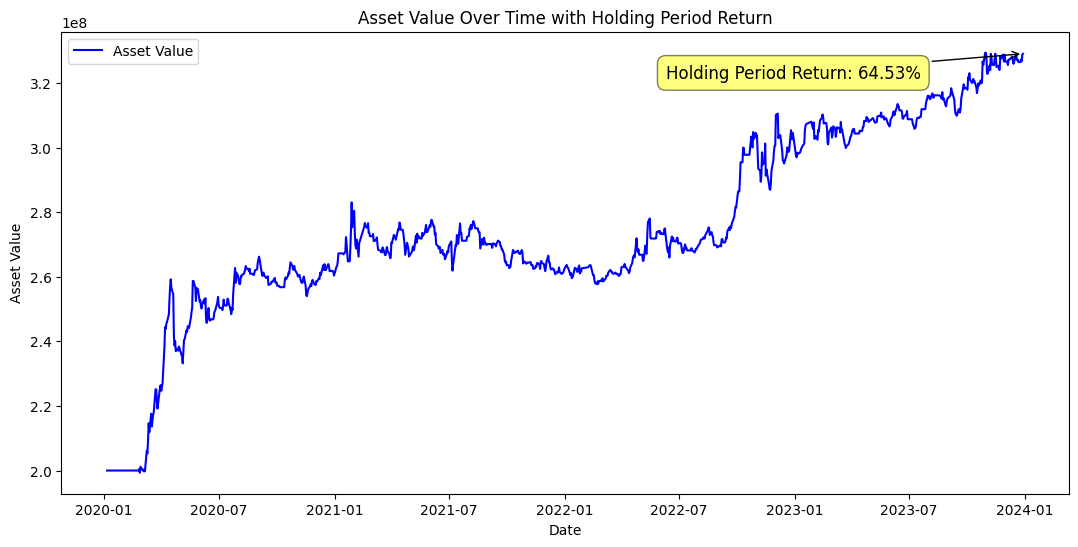

-10.034675664030178
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Peak date: 2020-04-16 00:00:00
Trough date: 2020-05-05 00:00:00
MDD: -10.034675664030178 %


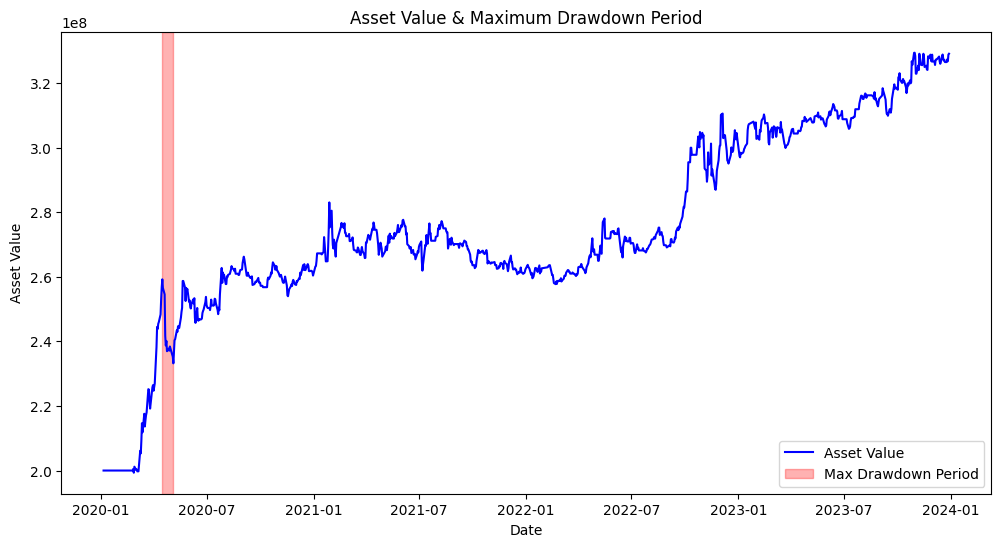

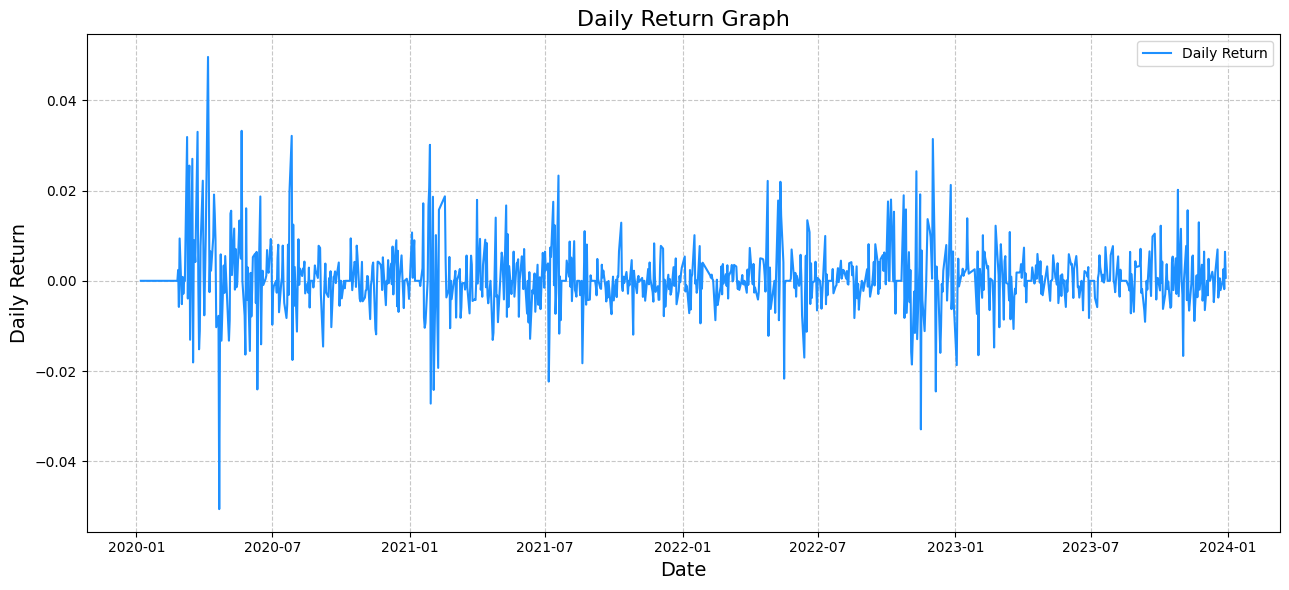

Sharpe Ratio:  0.8713923870809375


In [56]:
init_date = result.index[0]
cur_date = result.index[-1]
cur_asset_value = result['Asset'].iloc[-1]
init_asset_value = result['Asset'].iloc[0]
accum_return_rate = (cur_asset_value / init_asset_value - 1) * 100
print(f"Holding Period Return: {accum_return_rate:.2f}%")
print(f"Holding Period: từ {init_date} đến {cur_date}")


plt.figure(figsize=(13, 6))
plt.plot(result.index, result['Asset'], label='Asset Value', color='blue')
plt.xlabel('Date')
plt.ylabel('Asset Value')
plt.title('Asset Value Over Time with Holding Period Return')
plt.annotate(
    f"Holding Period Return: {accum_return_rate:.2f}%", xy = (data.index[-1], cur_asset_value),
    xytext = (0.6, 0.9), textcoords = 'axes fraction', arrowprops = dict(facecolor = 'black', arrowstyle = '->'),
    bbox = dict(boxstyle = 'round, pad = 0.5', fc = 'yellow', alpha = 0.5), fontsize = 12
)
plt.legend()
plt.show()

mdd_value = maximum_drawdown(result)
print(mdd_value)
trough_date = result['drawdown'].idxmin()
print(type(trough_date))

# ----------------------------
peak_date = result.loc[:trough_date, 'Asset'].idxmax()
print("Peak date:", peak_date)
print("Trough date:", trough_date)
print("MDD:", result['drawdown'].min() * 100, "%")
plt.figure(figsize=(12, 6))
plt.plot(data.index, result['Asset'], label='Asset Value', color='blue')
plt.axvspan(float(mdates.date2num(trough_date)), float(mdates.date2num(peak_date)), color = 'red', alpha = 0.3, label = 'Max Drawdown Period')
plt.xlabel('Date')
plt.ylabel('Asset Value')
plt.title('Asset Value & Maximum Drawdown Period')
plt.legend()
plt.show()


# ------------------------------

daily_return = result['Asset'].pct_change().dropna()
plt.figure(figsize = (13, 6))
plt.plot(result.index[1:], daily_return, linestyle = '-', color = 'dodgerblue', label = 'Daily Return')
plt.title("Daily Return Graph", fontsize = 16)
plt.xlabel("Date", fontsize = 14)
plt.ylabel("Daily Return", fontsize = 14)
plt.legend()
plt.grid(True, linestyle='--', alpha = 0.7)
plt.tight_layout()
plt.show()
sharpe = sharpe_ratio(result)
print("Sharpe Ratio: ", sharpe)

## Dynamic

In [57]:
MOMENTUM_FAST_EMA = 7
MOMENTUM_SLOW_EMA = 34
MOMENTUM_SIGNAL_EMA = 5
MOMENTUM_RSI_WINDOW = 14
MOMENTUM_RSI_THRESHOLD = 22
MOMENTUM_ATR_WINDOW = 14

REVERSION_FAST_EMA = 14
REVERSION_SLOW_EMA = 29
REVERSION_SIGNAL_EMA = 11
REVERSION_RSI_WINDOW = 11
REVERSION_ATR_WINDOW = 5

In [58]:
result = dynamic_algo(
    data,
    MOMENTUM_FAST_EMA, MOMENTUM_SLOW_EMA, MOMENTUM_SIGNAL_EMA,MOMENTUM_RSI_WINDOW, MOMENTUM_RSI_THRESHOLD, MOMENTUM_ATR_WINDOW,
    REVERSION_FAST_EMA, REVERSION_SLOW_EMA, REVERSION_SIGNAL_EMA, REVERSION_RSI_WINDOW, REVERSION_ATR_WINDOW
)

Holding Period Return: 53.44%
Holding Period: từ 2020-01-06 00:00:00 đến 2023-12-29 00:00:00


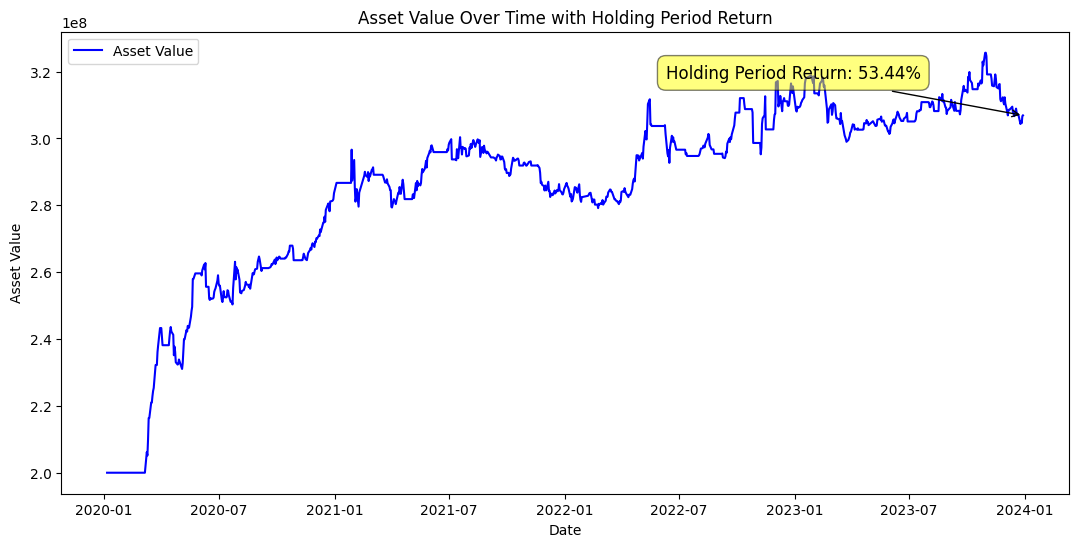

-7.060675691956575
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Peak date: 2021-07-19 00:00:00
Trough date: 2022-02-23 00:00:00
MDD: -7.060675691956575 %


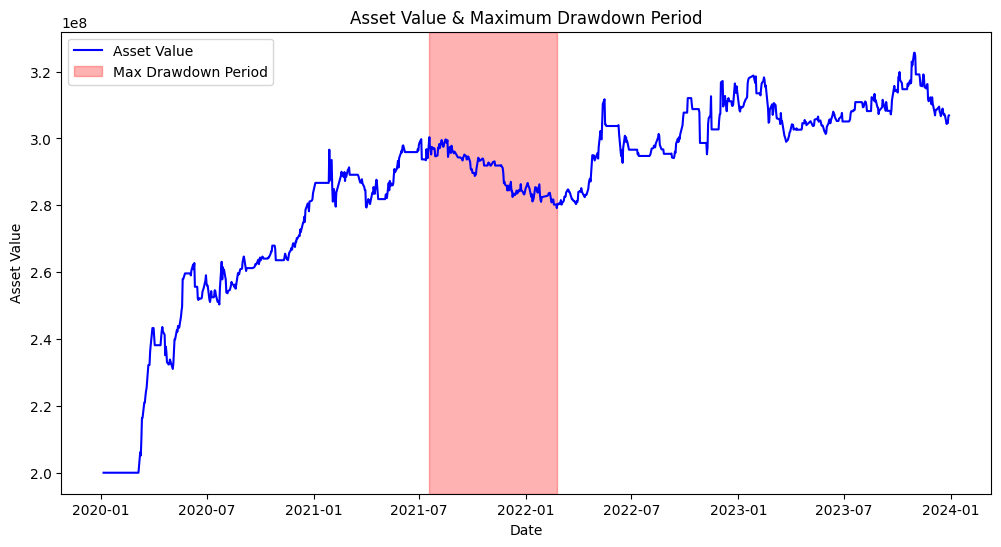

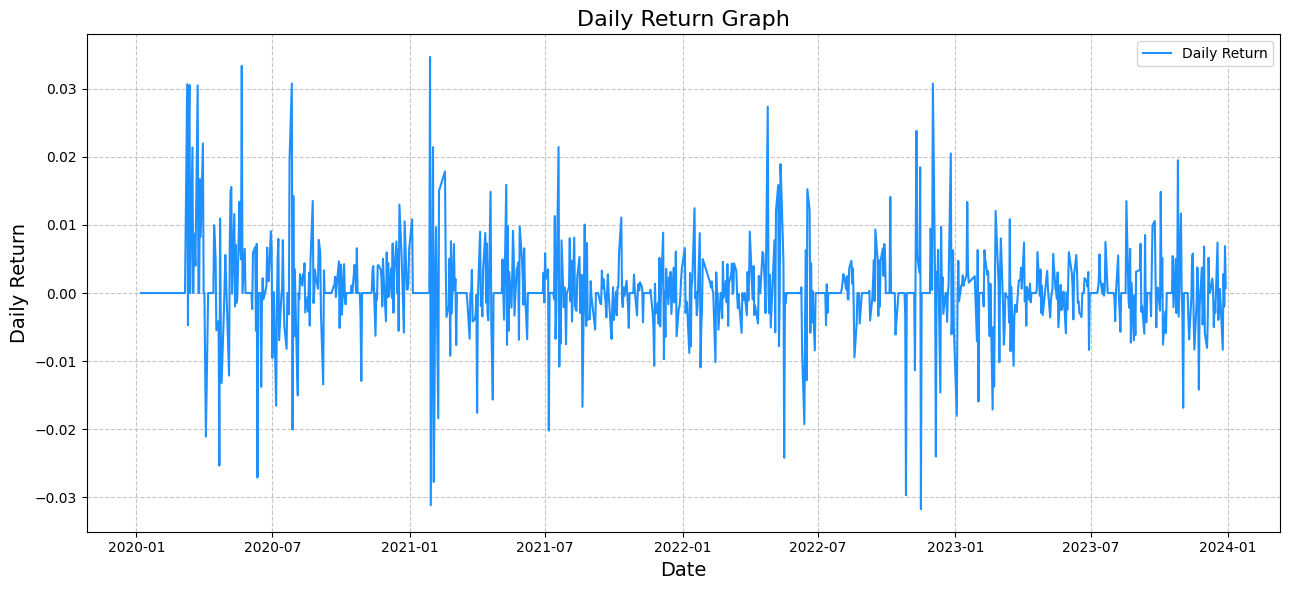

Sharpe Ratio:  0.7976709297575802


In [59]:
init_date = result.index[0]
cur_date = result.index[-1]
cur_asset_value = result['Asset'].iloc[-1]
init_asset_value = result['Asset'].iloc[0]
accum_return_rate = (cur_asset_value / init_asset_value - 1) * 100
print(f"Holding Period Return: {accum_return_rate:.2f}%")
print(f"Holding Period: từ {init_date} đến {cur_date}")


plt.figure(figsize=(13, 6))
plt.plot(result.index, result['Asset'], label='Asset Value', color='blue')
plt.xlabel('Date')
plt.ylabel('Asset Value')
plt.title('Asset Value Over Time with Holding Period Return')
plt.annotate(
    f"Holding Period Return: {accum_return_rate:.2f}%", xy = (data.index[-1], cur_asset_value),
    xytext = (0.6, 0.9), textcoords = 'axes fraction', arrowprops = dict(facecolor = 'black', arrowstyle = '->'),
    bbox = dict(boxstyle = 'round, pad = 0.5', fc = 'yellow', alpha = 0.5), fontsize = 12
)
plt.legend()
plt.show()

mdd_value = maximum_drawdown(result)
print(mdd_value)
trough_date = result['drawdown'].idxmin()
print(type(trough_date))

# ----------------------------
peak_date = result.loc[:trough_date, 'Asset'].idxmax()
print("Peak date:", peak_date)
print("Trough date:", trough_date)
print("MDD:", result['drawdown'].min() * 100, "%")
plt.figure(figsize=(12, 6))
plt.plot(data.index, result['Asset'], label='Asset Value', color='blue')
plt.axvspan(float(mdates.date2num(trough_date)), float(mdates.date2num(peak_date)), color = 'red', alpha = 0.3, label = 'Max Drawdown Period')
plt.xlabel('Date')
plt.ylabel('Asset Value')
plt.title('Asset Value & Maximum Drawdown Period')
plt.legend()
plt.show()


# ------------------------------

daily_return = result['Asset'].pct_change().dropna()
plt.figure(figsize = (13, 6))
plt.plot(result.index[1:], daily_return, linestyle = '-', color = 'dodgerblue', label = 'Daily Return')
plt.title("Daily Return Graph", fontsize = 16)
plt.xlabel("Date", fontsize = 14)
plt.ylabel("Daily Return", fontsize = 14)
plt.legend()
plt.grid(True, linestyle='--', alpha = 0.7)
plt.tight_layout()
plt.show()
sharpe = sharpe_ratio(result)
print("Sharpe Ratio: ", sharpe)